In [ ]:
 !nvidia-smi

Fri Dec 25 07:00:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Generating Animation


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math 
import matplotlib.animation as animation
m = 1
l = 1 
g = 9.8 
#c = 0.05
def equation(y0,t,m,l,g):
  theta , x = y0
  f = [x, -(g/l)*np.sin(theta)]
  return f 
y0 = [np.pi/2 , 0.5]
t = np.linspace(0,6,600)
ans = odeint(equation,y0,t,args=(m,l,g))

fig ,ax = plt.subplots()
mylist =[]
for i in range(len(ans)):
  #fig,ax = plt.subplots()
  line, = ax.plot([0,np.sin(ans[i,0])],[0,-np.cos(ans[i,0])],color='black',lw=4 )
  ball, = ax.plot(np.sin(ans[i,0]),-np.cos(ans[i,0]),'o',markersize =35,color='blue')
  time = ax.text(-0.75,0,"Time is:"+"{:.2f}".format(t[i]))
  mylist.append([line,ball,time])
ax.set_aspect('equal','datalim')
result = animation.ArtistAnimation(fig,mylist,interval=50)
result.save('/content/drive/MyDrive/animation.mp4',writer='ffmpeg' ,fps=20)

##Generating pictures

In [ ]:
import cv2 
myvideo = cv2.VideoCapture("/content/drive/MyDrive/animation.mp4")
framenumber = 0
while(True):
    cap,frame = myvideo.read()
    if cap :
        cv2.imwrite('/content/drive/MyDrive/MP2Q1data/frame'+str(framenumber)+'.jpg',frame)
        framenumber += 1 
    else :
        break
myvideo.release()
cv2.destroyAllWindows()

##Pre processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

In [ ]:
data = []
for i in range(600):
  myimage = Image.open('/content/drive/My Drive/MP2Q1data/frame{}.jpg'.format(str(i)))
  myimage = myimage.resize((80, 80))
  myimage = asarray(myimage)
  myimage = myimage/255
  data.append(myimage)

data = np.array(data)

In [ ]:
test_data = data[551:]
train_data = data[:551]
x_tt = train_data[:-1] # all but the last
y_tt = train_data[1:] # all but the first
x_test = test_data[:-1]
y_test = test_data[1:]
test_data = test_data[:-8]
x_test = test_data[:-1]
y_test = test_data[1:]

In [ ]:
xtrainnew = []
ytrainnew = []
xvalidnew = []
yvalidnew = []
xtestnew = []
ytestnew = []
for i in range(540):
  xtrainnew.append(x_tt[i:i+10])
  ytrainnew.append(y_tt[i:i+10][-1])
ytrainnew = np.array(ytrainnew)
ytrainnew = ytrainnew.reshape(540,1,80,80,3)
xtrainnew = np.array(xtrainnew)

for i in range(30):
  xtestnew.append(x_test[i:i+10])
  ytestnew.append(y_test[i:i+10][-1])

xtestnew = np.array(xtestnew)
ytestnew = np.array(ytestnew)
ytestnew = ytestnew.reshape(30,1,80,80,3)

In [ ]:
from keras import layers,Model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,GlobalMaxPool2D,Conv2DTranspose,UpSampling2D
from keras.layers import Flatten,Dropout
from keras.optimizers import SGD , Adam
from keras.layers import BatchNormalization
from keras.layers import LSTM,SimpleRNN,GRU
from keras.layers import TimeDistributed

##Functions(Netwrok Model/Histroy Plot/Animation of Prediction


In [ ]:
def finalmodel(n,opt,lfunc):
  model = Sequential()
  ##Encoder Part
  model.add(TimeDistributed(Conv2D(27, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same',input_shape=(10,80,80,3))))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Conv2D(18, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Conv2D(9, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Conv2D(4, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same')))
  model.add(TimeDistributed(Flatten()))
  ###
  ##LSTM Part
  if n == 1 :
    model.add((SimpleRNN(500,activation='tanh',kernel_initializer='he_uniform',return_sequences=False)))
    model.add(layers.Reshape((1,10,10,5)))
  elif n==2 :
    model.add((GRU(500,activation='tanh',kernel_initializer='he_uniform',return_sequences=False)))
    model.add(layers.Reshape((1,10,10,5)))
  elif n==3 : 
    model.add((LSTM(500,activation='tanh',kernel_initializer='he_uniform',return_sequences=False)))
    model.add(layers.Reshape((1,10,10,5)))
  ##
  ##Decoder part
  model.add(TimeDistributed(Conv2D(4, (3, 3), activation='relu',kernel_initializer='he_uniform',  padding='same')))
  model.add(TimeDistributed(UpSampling2D((2,2))))
  model.add(TimeDistributed(Conv2D(9, (3, 3), activation='relu',kernel_initializer='he_uniform',  padding='same')))
  model.add(TimeDistributed(UpSampling2D((2,2))))
  model.add(TimeDistributed(Conv2D(18, (3, 3), activation='relu',kernel_initializer='he_uniform',  padding='same')))
  model.add(TimeDistributed(UpSampling2D((2,2))))
  model.add(TimeDistributed(Conv2D(27, (3, 3), activation='relu',kernel_initializer='he_uniform',  padding='same')))
  model.add(TimeDistributed(Conv2D(3, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same')))
  model.compile(optimizer = opt , loss = lfunc)
  return model


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math 
import matplotlib.animation as animation
def animationpred(n,nof):
  i = 0 
  output = []
  m = 0
  xtestlist = xtestnew[0]
  xtestlist=xtestlist.reshape(1,10,80,80,3)
  plt.imshow(xtestlist[0][-1])
  if n == 1 :
    ypred = rnnmodel.predict(xtestlist)
  elif n==2 :
    ypred = grumodel.predict(xtestlist)
  elif n==3 : 
    ypred = lstmmodel.predict(xtestlist)
  fig = plt.figure()
  while i<=nof :
    im = plt.imshow(ypred[0][-1],animated = True)
    output.append([im])
    xtestlist = np.append(xtestlist[0],np.array([(ypred[0][-1])]),axis=0)
    xtestlist = xtestlist.reshape(1,11,80,80,3)
    xtestlist = np.delete(xtestlist[0],0,axis=0)
    xtestlist = xtestlist.reshape(1,10,80,80,3)
    if n == 1 :
      ypred = rnnmodel.predict(xtestlist)
    elif n==2 :
      ypred = grumodel.predict(xtestlist)
    elif n==3 : 
      ypred = lstmmodel.predict(xtestlist)
    i += 1 
  
  ani = animation.ArtistAnimation(fig, output, interval=50, blit=True)
  if n == 1 :
    ani.save('/content/drive/MyDrive/RNNFinal/RNNanimation{}.mp4'.format(nof),writer='ffmpeg' ,fps=20)
  elif n==2 :
    ani.save('/content/drive/MyDrive/GRUFinal/GRUanimation{}.mp4'.format(nof),writer='ffmpeg' ,fps=20)
  elif n==3 : 
    ani.save('/content/drive/MyDrive/LSTMFinal/LSTManimation{}.mp4'.format(nof),writer='ffmpeg' ,fps=20)

In [ ]:
def plot_loss(history,title):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cost')
  plt.title(title)
  plt.legend()
  plt.grid()

##LSTM

In [ ]:
lstmmodel = finalmodel(3,'adam','mse')

In [ ]:
lstmhistory = lstmmodel.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 11s 45ms/step - loss: 0.3383 - val_loss: 0.0299
Epoch 2/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0251 - val_loss: 0.0164
Epoch 3/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0151 - val_loss: 0.0124
Epoch 4/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 5/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 6/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 7/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 8/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 9/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0074 - val_loss: 0.007

In [ ]:
lstmmodel.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_135 (TimeDi (None, 10, 80, 80, 27)    756       
_________________________________________________________________
time_distributed_136 (TimeDi (None, 10, 40, 40, 27)    0         
_________________________________________________________________
time_distributed_137 (TimeDi (None, 10, 40, 40, 18)    4392      
_________________________________________________________________
time_distributed_138 (TimeDi (None, 10, 20, 20, 18)    0         
_________________________________________________________________
time_distributed_139 (TimeDi (None, 10, 20, 20, 9)     1467      
_________________________________________________________________
time_distributed_140 (TimeDi (None, 10, 10, 10, 9)     0         
_________________________________________________________________
time_distributed_141 (TimeDi (None, 10, 10, 10, 4)   

In [ ]:
lstmmodel.evaluate(xtestnew,ytestnew)

1/1 [==============================] - 0s 55ms/step - loss: 1.8663e-04


0.00018663270748220384

In [ ]:
lstmmodel.save_weights('/content/drive/My Drive/LSTMFinal/lstmmodel.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

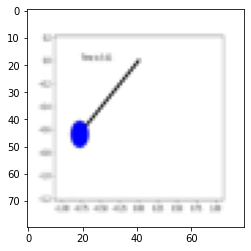

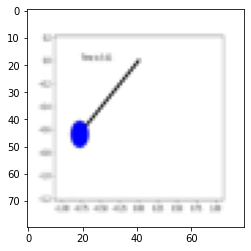

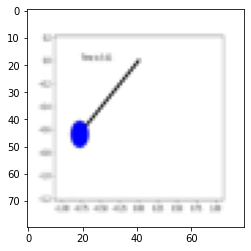

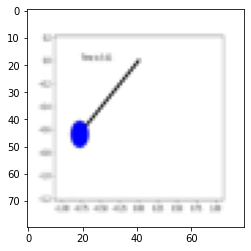

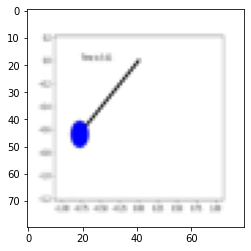

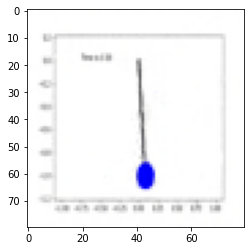

In [ ]:
noflist = [5,10,20,50,100]
for item in noflist:
  animationpred(3,item)

##GRU

In [ ]:
grumodel = finalmodel(2,'adam','mse')

In [ ]:
gruhistory = grumodel.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 4s 48ms/step - loss: 0.3934 - val_loss: 0.0313
Epoch 2/800
44/44 [==============================] - 2s 38ms/step - loss: 0.0261 - val_loss: 0.0177
Epoch 3/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 4/800
44/44 [==============================] - 2s 38ms/step - loss: 0.0133 - val_loss: 0.0118
Epoch 5/800
44/44 [==============================] - 2s 38ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 6/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 7/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 8/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 9/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 10/800
44/44 [==============================] - 2s 39ms/step - loss: 0.0083 - val_loss: 0.0082

In [ ]:
grumodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_80 (TimeDis (None, 10, 80, 80, 27)    756       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 10, 40, 40, 27)    0         
_________________________________________________________________
time_distributed_82 (TimeDis (None, 10, 40, 40, 18)    4392      
_________________________________________________________________
time_distributed_83 (TimeDis (None, 10, 20, 20, 18)    0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 10, 20, 20, 9)     1467      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 10, 10, 10, 9)     0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 10, 10, 10, 4)    

In [ ]:
grumodel.evaluate(xtestnew,ytestnew)

1/1 [==============================] - 0s 273ms/step - loss: 3.4877e-04


0.0003487715730443597

In [ ]:
grumodel.save_weights('/content/drive/My Drive/GRUFinal/grymodel.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

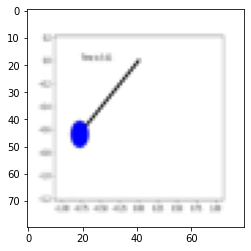

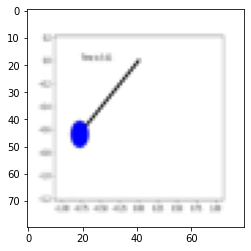

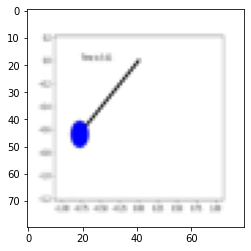

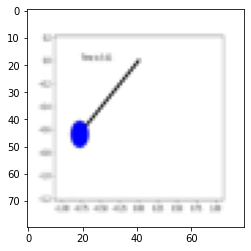

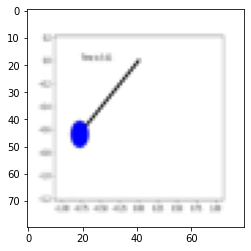

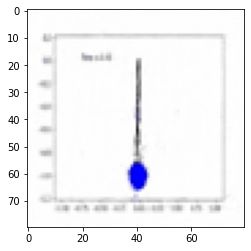

In [ ]:
noflist = [5,10,20,50,100]
for item in noflist:
  animationpred(2,item)

##RNN


In [ ]:
rnnmodel = finalmodel(1,'adam','mse')

In [ ]:
rnnhistory = rnnmodel.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 3s 32ms/step - loss: 0.2862 - val_loss: 0.0313
Epoch 2/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0270 - val_loss: 0.0193
Epoch 3/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0179 - val_loss: 0.0151
Epoch 4/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 5/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 6/800
44/44 [==============================] - 1s 23ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 7/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 8/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 9/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/800
44/44 [==============================] - 1s 22ms/step - loss: 0.0087 - val_loss: 0.0085

In [ ]:
rnnmodel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_160 (TimeDi (None, 10, 80, 80, 27)    756       
_________________________________________________________________
time_distributed_161 (TimeDi (None, 10, 40, 40, 27)    0         
_________________________________________________________________
time_distributed_162 (TimeDi (None, 10, 40, 40, 18)    4392      
_________________________________________________________________
time_distributed_163 (TimeDi (None, 10, 20, 20, 18)    0         
_________________________________________________________________
time_distributed_164 (TimeDi (None, 10, 20, 20, 9)     1467      
_________________________________________________________________
time_distributed_165 (TimeDi (None, 10, 10, 10, 9)     0         
_________________________________________________________________
time_distributed_166 (TimeDi (None, 10, 10, 10, 4)   

In [ ]:
rnnmodel.evaluate(xtestnew,ytestnew)

1/1 [==============================] - 0s 38ms/step - loss: 5.5385e-04


0.0005538530531339347

In [ ]:
rnnmodel.save_weights('/content/drive/My Drive/RNNFinal/rnnmodel.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

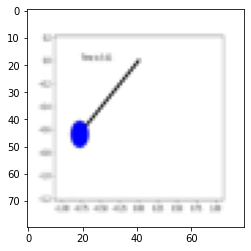

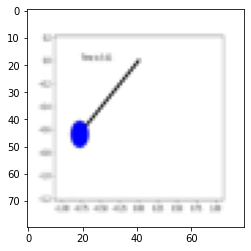

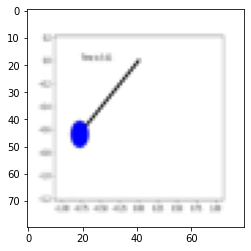

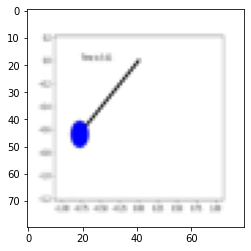

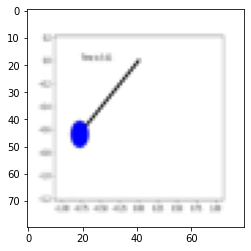

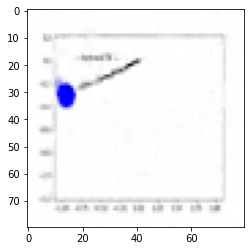

In [ ]:
noflist = [5,10,20,50,100]
for item in noflist:
  animationpred(1,item)

## Loss function

In [ ]:
## kstm/adam 
## loss model 1 == lstmmodel ##FINAL LOSS =  loss: 1.6769e-04 - val_loss: 2.5840e-04
lossmodel2 = finalmodel(3,'adam','mae')

In [ ]:
losshistory2 = lossmodel2.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 3s 32ms/step - loss: 0.3542 - val_loss: 0.1370
Epoch 2/800
44/44 [==============================] - 1s 20ms/step - loss: 0.1182 - val_loss: 0.0776
Epoch 3/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0698 - val_loss: 0.0537
Epoch 4/800
44/44 [==============================] - 1s 19ms/step - loss: 0.0510 - val_loss: 0.0446
Epoch 5/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0441 - val_loss: 0.0401
Epoch 6/800
44/44 [==============================] - 1s 19ms/step - loss: 0.0393 - val_loss: 0.0368
Epoch 7/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0363 - val_loss: 0.0351
Epoch 8/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0346 - val_loss: 0.0335
Epoch 9/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0334 - val_loss: 0.0331
Epoch 10/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0324 - val_loss: 0.0316

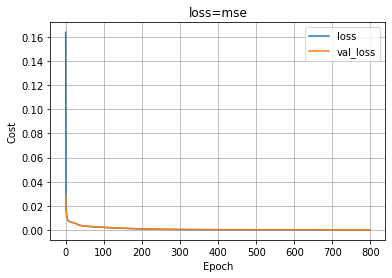

In [ ]:
plot_loss(lstmhistory,'loss=mse')

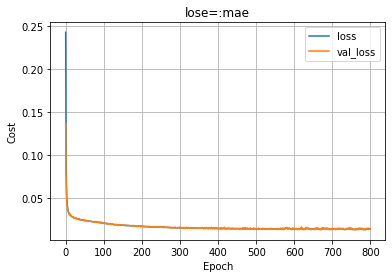

In [ ]:
plot_loss(losshistory2,'lose=:mae')

In [ ]:
lossmodel3 = finalmodel(3,'adam','huber')

In [ ]:
losshistory3 = lossmodel3.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 4s 34ms/step - loss: 0.1153 - val_loss: 0.0131
Epoch 2/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 3/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 4/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 6/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/800
44/44 [==============================] - 1s 20ms/step - loss: 0.0038 - val_loss: 0.0037

In [ ]:
lossmodel4 = finalmodel(3,'adam','categorical_crossentropy')

In [ ]:
losshistory4 = lossmodel4.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 4s 33ms/step - loss: nan - val_loss: 3.2352
Epoch 2/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2274 - val_loss: 3.2184
Epoch 3/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2180 - val_loss: 3.2165
Epoch 4/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2163 - val_loss: 3.2152
Epoch 5/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2152 - val_loss: 3.2144
Epoch 6/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2144 - val_loss: 3.2137
Epoch 7/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2138 - val_loss: 3.2133
Epoch 8/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2134 - val_loss: 3.2130
Epoch 9/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2131 - val_loss: 3.2127
Epoch 10/800
44/44 [==============================] - 1s 20ms/step - loss: 3.2128 - val_loss: 3.2124
Ep

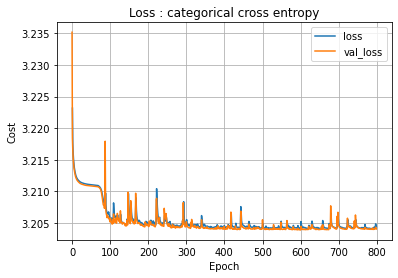

In [ ]:
plot_loss(losshistory4,'Loss : categorical cross entropy')

## Optimizer 

In [ ]:
## kstm/adam 
## optimizer model 1 == lstmmodel ##FINAL LOSS =  loss: 1.6769e-04 - val_loss: 2.5840e-04
optimizermodel2 = finalmodel(3,'RMSProp','mse')

In [ ]:
optimizerhistory2 = optimizermodel2.fit(xtrainnew,ytrainnew,epochs = 800, batch_size = 10,validation_split = 0.2 ,verbose = 1)

Epoch 1/800
44/44 [==============================] - 4s 34ms/step - loss: 0.2445 - val_loss: 0.0450
Epoch 2/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0388 - val_loss: 0.0286
Epoch 3/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0276 - val_loss: 0.0283
Epoch 4/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0228 - val_loss: 0.0208
Epoch 5/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 6/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0186 - val_loss: 0.0151
Epoch 7/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 8/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0156 - val_loss: 0.0146
Epoch 9/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 10/800
44/44 [==============================] - 1s 21ms/step - loss: 0.0135 - val_loss: 0.0139

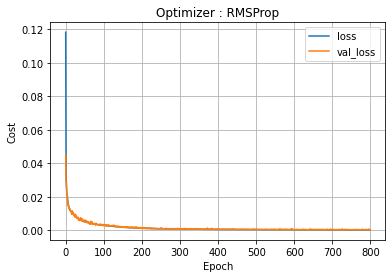

In [ ]:
plot_loss(optimizerhistory2,'Optimizer : RMSProp')

## Data for report


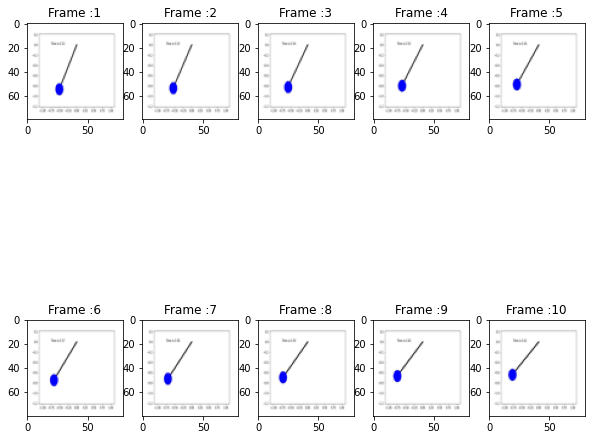

In [ ]:
xtestlist = xtestnew[0]
xtestlist=xtestlist.reshape(1,10,80,80,3)
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(xtestlist[0][i])
  plt.title('Frame :{}'.format(i+1))

In [ ]:
def one_frame(model):
  ypred = model.predict(xtestnew)
  plt.figure(figsize=(15,15))
  plt.subplot(3,1,1)
  plt.imshow(xtestnew[1][-1])
  plt.grid()
  plt.title("First Frame  - real")

  plt.subplot(3,1,2)
  plt.imshow(ytestnew[1][-1])
  plt.grid()
  plt.title("Next Frame - real")

  plt.subplot(3,1,3)
  plt.imshow(ypred [1][-1])
  plt.grid()
  plt.title("Next Frame  -predicted")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


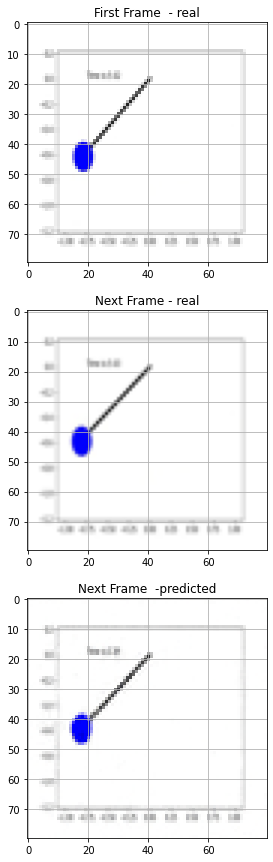

In [ ]:
one_frame(lstmmodel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


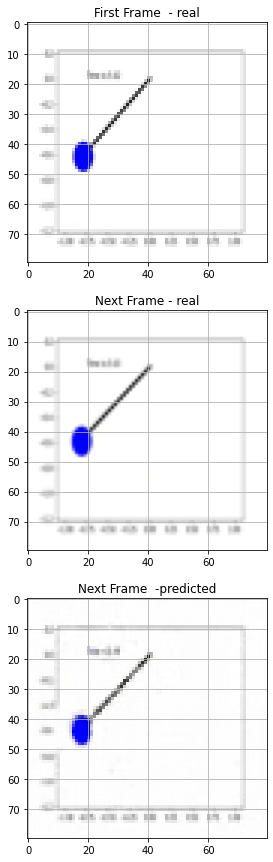

In [ ]:
one_frame(grumodel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


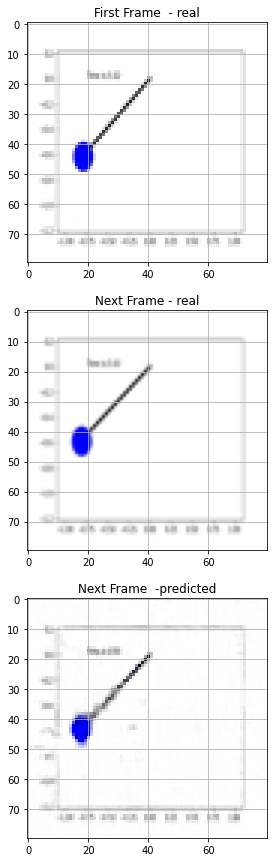

In [ ]:
one_frame(rnnmodel)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


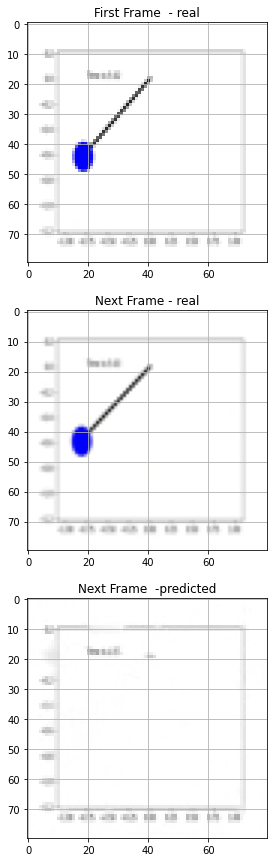

In [ ]:
one_frame(lossmodel2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


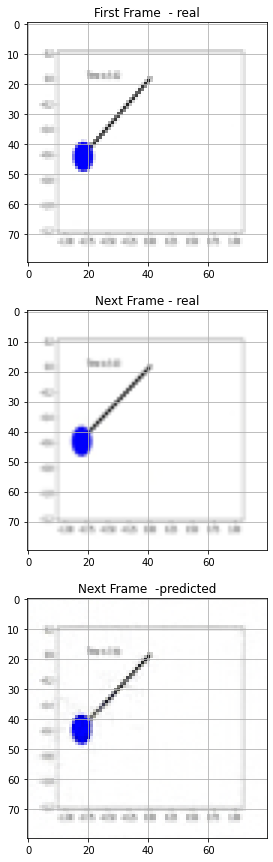

In [ ]:
one_frame(lossmodel3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


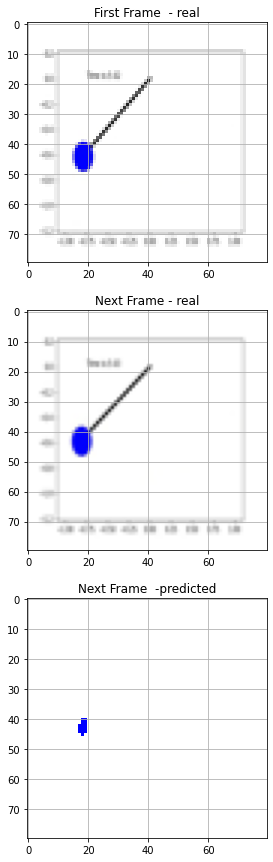

In [ ]:
one_frame(lossmodel4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


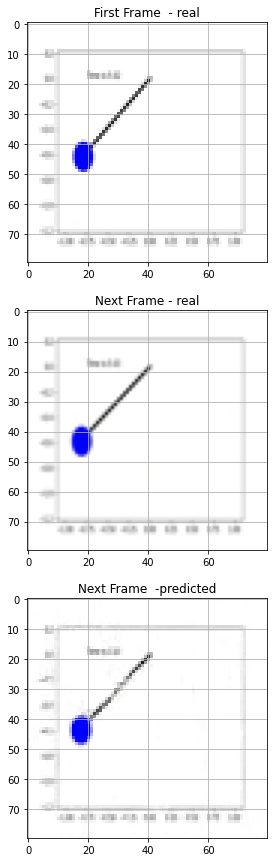

In [ ]:
one_frame(optimizermodel2)